In [1]:
import os
import sys
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc
from absl import app
from absl import flags
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import Optimizer
from tqdm import tqdm

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader,Subset
import torchvision.models as models
from model import *
from utils import train,eval_,mia,_Mentr,metric_scores

In [2]:
import setGPU

setGPU: Setting GPU to: 0


In [3]:
dataset_path='/home/nikhilsa/data/'

In [5]:
#The argumention use for all training set
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#The argumention use for all testing set
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

ori_train = torchvision.datasets.CIFAR10(root=dataset_path, train=True, download=False, transform=transform_train)
ori_test = torchvision.datasets.CIFAR10(root=dataset_path, train=False, download=False, transform=transform_test)

In [6]:
ori_train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /home/nikhilsa/data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

#### Train Data

In [7]:
idx = len(ori_train)//4
target_train = np.arange(2*idx)
target_test = np.arange(2*idx,4*idx)
shadow_train = np.arange(2*idx, 3*idx)
shadow_test = np.arange(3*idx, 4*idx)

In [8]:
train_dataset = Subset(ori_train, target_train)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(ori_test, batch_size=256, shuffle=True, num_workers=8)

#### Model Training

In [10]:
target_model = ResNet18().cuda()

epochs = 25
criterion = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(params=target_model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
train_model = target_model

In [11]:
save_name = 'clean_model'

In [12]:
print(f'Training the {save_name}')
train(train_model, epochs, opt, criterion, scheduler, train_loader, val_loader, save_name)

Training the clean_model
Epoch:1, Loss: 1.614 Train accuracy: 40.88 Test accuracy: 47.93
Epoch:2, Loss: 1.138 Train accuracy: 58.65 Test accuracy: 52.69
Epoch:3, Loss: 0.916 Train accuracy: 67.09 Test accuracy: 66.03
Epoch:4, Loss: 0.755 Train accuracy: 73.23 Test accuracy: 67.89
Epoch:5, Loss: 0.618 Train accuracy: 78.25 Test accuracy: 70.21
Epoch:6, Loss: 0.490 Train accuracy: 82.91 Test accuracy: 72.09
Epoch:7, Loss: 0.373 Train accuracy: 86.86 Test accuracy: 74.06
Epoch:8, Loss: 0.267 Train accuracy: 90.70 Test accuracy: 76.23
Epoch:9, Loss: 0.170 Train accuracy: 94.13 Test accuracy: 75.22
Epoch:10, Loss: 0.114 Train accuracy: 96.13 Test accuracy: 70.92
Epoch:11, Loss: 0.060 Train accuracy: 98.05 Test accuracy: 78.87
Epoch:12, Loss: 0.023 Train accuracy: 99.40 Test accuracy: 79.40
Epoch:13, Loss: 0.009 Train accuracy: 99.85 Test accuracy: 80.25
Epoch:14, Loss: 0.003 Train accuracy: 99.95 Test accuracy: 81.65
Epoch:15, Loss: 0.001 Train accuracy: 100.00 Test accuracy: 81.52
Epoch:16

#### Membership Inference

In [13]:
eval_model = ResNet18().cuda()

In [14]:
save_name = 'clean_model'

In [15]:
save_path = f'./checkpoint/{save_name}_' + f'{epochs}' +'.pth'
eval_model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [16]:
np.random.seed(0)
mi_idx=np.random.choice(target_train, size=1000, replace=False)

In [19]:
mask = np.zeros(len(target_train), dtype=bool)
mask[mi_idx] = True

#### MIA Dataloaders

In [20]:
member_dataset = torch.utils.data.Subset(ori_train, target_train[mask])
non_member_dataset = torch.utils.data.Subset(ori_train, target_test[mask])

test_set = torch.utils.data.ConcatDataset([member_dataset, non_member_dataset])
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

In [24]:
mem_groundtruth = np.ones(int(len(test_loader.dataset)/2))
non_groundtruth = np.zeros(int(len(test_loader.dataset)/2))
groundtruth = np.concatenate((mem_groundtruth, non_groundtruth))

In [21]:
predictions, targets, loss = eval_(eval_model, test_loader, criterion)

In [22]:
loss_score, max_score, _Mentr_score = metric_scores(predictions, targets, loss, test_loader)

In [25]:
mia_mentr, low_mentr, acc_mentr, fpr_mentr, tpr_mentr = mia(groundtruth, predictions, targets, loss, test_loader, _Mentr_score)
mia_loss, low_loss, acc_loss, fpr_loss, tpr_loss = mia(groundtruth, predictions, targets, loss, test_loader, loss_score)
mia_max, low_max, acc_max, fpr_max, tpr_max = mia(groundtruth, predictions, targets, loss, test_loader, max_score)

print('Modified Entropy\n AUC %.4f, Accuracy %.4f, TPR@0.1%%FPR of %.4f'% (mia_mentr,acc_mentr, low_mentr))
print('Maximum\n AUC %.4f, Accuracy %.4f, TPR@0.1%%FPR of %.4f'% (mia_max,acc_max, low_max))
print('Loss\n AUC %.4f, Accuracy %.4f, TPR@0.1%%FPR of %.4f'% (mia_loss,acc_loss, low_loss))

Modified Entropy
 AUC 0.6856, Accuracy 0.7060, TPR@0.1%FPR of 0.0020
Maximum
 AUC 0.6792, Accuracy 0.6935, TPR@0.1%FPR of 0.0000
Loss
 AUC 0.6845, Accuracy 0.7045, TPR@0.1%FPR of 0.0000


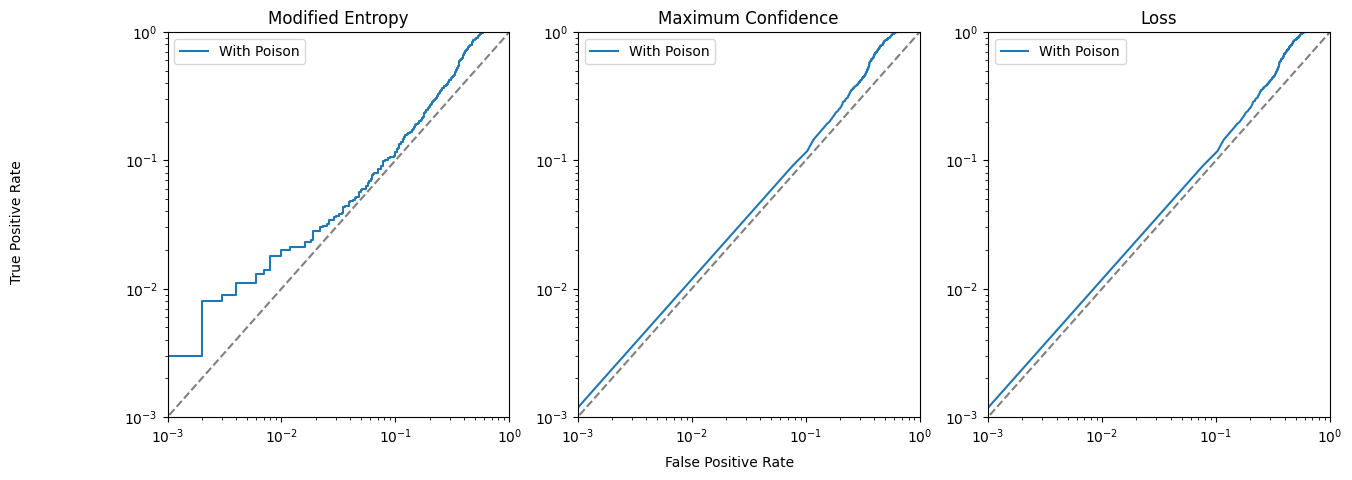

In [26]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fig = plt.figure(figsize=(15, 5))

ax1 = plt.subplot(1, 3, 1)
plt.semilogx()
plt.semilogy()
plt.xlim(1e-3,1)
plt.ylim(1e-3,1)
plt.plot([0, 1], [0, 1], ls='--', color='gray')
ax1.plot(fpr_mentr, tpr_mentr, label="With Poison")
ax1.set_title('Modified Entropy')
ax1.legend()

ax2 = plt.subplot(1, 3, 2)
plt.semilogx()
plt.semilogy()
plt.xlim(1e-3,1)
plt.ylim(1e-3,1)
plt.plot([0, 1], [0, 1], ls='--', color='gray')
ax2.plot(fpr_max, tpr_max, label="With Poison")
ax2.set_title("Maximum Confidence")
ax2.legend()

ax3 = plt.subplot(1, 3, 3)
plt.semilogx()
plt.semilogy()
plt.xlim(1e-3,1)
plt.ylim(1e-3,1)
plt.plot([0, 1], [0, 1], ls='--', color='gray')
ax3.plot(fpr_loss, tpr_loss, label="With Poison")
ax3.set_title("Loss")
ax3.legend()

fig.text(0.5, 0.01, 'False Positive Rate', ha='center');
fig.text(0.02, 0.5, 'True Positive Rate', va='center', rotation='vertical');